In [76]:
#!/usr/bin/env python3
# coding: utf-8

# Data-related libraries
import numpy as np
import netCDF4 as nc
import datetime
import pandas as pd

# Plotting-related libraries
import matplotlib
import matplotlib.pyplot as plt
from cartopy import crs as ccrs, feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# OS-specific libraries
import sys
import os, glob


# Project custom made libaries
sys.path.append('/mnt/storage0/luiz/ANALYSES/SCRIPTS/PYTHON/ANHALIZE/anhalyze/')
import anhalyze_plot_utils as apu
import anhalyze_utils as au

In [67]:
# Setting up Baffin Bay location
east = -48
west = -81
north = 80
south = 64

lat_range  = (south,north)
lon_range = (west,east)

# Setting up data specific params
run = 'ANHA4-WJM004'
years_list = [str(yyyy) for yyyy in np.arange(2005,2018,1)]
grid = 'gridT' # to do: add Options: T, B, U, V, W, and icemod
#month_list = ['{:02d}'.format(mm) for mm in np.arange(6,9,1)]
depth = 50 # Depth level
var = 'votemper'

In [3]:
def get_paths(run='ANHA4-WJM004'):
    """ Get paths to data and mask standard locations."""

    run = run.upper()
    
    if sys.platform == "linux" or sys.platform == "linux2":
        # linux
        # setup paths
        # Set directory and sections mask file
        
        if any([x in run.split('-')[1][1:3].upper() for x in ["JM","PM"]]):
    
            mask_path = "/mnt/storage0/jmarson/ANALYSES/MASKS/"
            data_path = '/mnt/storage0/jmarson/NEMO/ANHA4/{}-S/'.format(run)
        
        
        elif run.split('-')[1][1:3].upper() == 'MC':
            user = os.environ['USER']
            
            mask_path = "/mnt/storage0/{}/ANALYSES/MASKS/".format(user)
            data_path = '/mnt/storage0/madhurima/NEMO/ANHA4/{}-S/'.format(run)
        
        else:
            data_path = ''
            mask_path = ''
        
    else:
        data_path = ''
        mask_path = ''
        # raise ValueError("Platform not recognized.")

    return data_path, mask_path

In [4]:
def get_file_list(run='ANHA4-WJM004',grid=None, years_list=None, month_list=None, one_per_month=False, monthly_mean=False):
        """  Returns file list given a list of years, a grid type,
             and either all the days in a month, or the first one.
        """

        # Setup
        selected_file_list = []
        monthly_file_list = []
        if month_list is None:
            month_list = []

            
        # Get paths
        data_path, mask_path = get_paths(run=run)
        
        if monthly_mean:
            print('---------------------------')
            data_path = str(input('Insert monthly averaged data path: '))
        
        # Get complete file list from path
        file_list = os.listdir(data_path)

        # Selecting list of files given params
        for year in years_list:
            selected_file_list += (sorted([f for f in file_list if '_y'+year in f and '_'+grid in f]))

        # Selecting first day on given month
        if one_per_month:
            if not month_list:
                month_list = [get_date(filename, how='m') for filename in selected_file_list]

            for year in years_list:
                for month in month_list:
                    file_name_stump = 'y{}m{}'.format(year, month)
                    file_month_name = [f for f in selected_file_list if file_name_stump in f][0]
                    monthly_file_list.append(file_month_name)
        else:
            # Make month selection
            if month_list:
                for year in years_list:
                    for month in month_list:
                        file_name_stump = 'y{}m{}'.format(year, month)
                        file_month_names = [f for f in selected_file_list if file_name_stump in f]
                        monthly_file_list += file_month_names

        if monthly_file_list:
            selected_file_list = monthly_file_list

        # Adding full path to filenames
        selected_file_list = [data_path+filename for filename in selected_file_list]

        return selected_file_list

In [37]:
def getVar_region(run, grid, depth, lon_range,lat_range,var,years_list, month_list=None, one_per_month=False,monthly_mean=False,masked=True,cardinal=True):
    
    """
    
    Extract a variable in an pre-defined area from ANHA4 domain.
    
    Inputs:
    run = Simulation (i.e. ANHA4-WJM004); type: string
    grid = Variable model grid (i.e. griT, gridB, icemod); type: string
    depth = Number of depth levels, including surface; type: integer
    lon_range = A list with west and east region limits; type: integer/float
    lat_range = A list with south and north region limits; type: integer/float
    var = Variable name (i.e. votemper, vosaline); type: string
    years_list = List made of all years of interest; type: string
    month_list = List made of all years of interest; type: string
    one_per_month = If True, extract just the first day of each month
    monthly_mean = If True, ask the user to input the monthly mean directory, since this is not
                   a standard PORTAL output format.
    
    """
    
    # Get mask path
    data_path, mask_path = get_paths(run=run)
    
    # Get file names list
    file_list = get_file_list(run=run,grid=grid, years_list=years_list, month_list=month_list, one_per_month=one_per_month, monthly_mean=monthly_mean)
    
    # Get depth levels
    depth_levels = nc.Dataset(file_list[0])['deptht'][:depth]
    
    # Get latitude and longitude limits and indices
    if cardinal:
        row_range, col_range = get_row_col_range(nc.Dataset(file_list[0]),grid, lat_range, lon_range)
    else:
        row_range, col_range = lat_range, lon_range

    # Get the region land/ocean mask
    mask_region = getMask_region(run,row_range,col_range)

    # For tracers
    if grid == 'gridT':
        
        # Get latitude and longitude
        lon = nc.Dataset(file_list[0])['nav_lon_grid_T'][row_range[0]:row_range[1],col_range[0]:col_range[1]]
        lon[lon == 0] = np.nan
        lat = nc.Dataset(file_list[0])['nav_lat_grid_T'][row_range[0]:row_range[1],col_range[0]:col_range[1]]
        lat[lat == 0] = np.nan
        
        # Prealocating variable
        var_region = np.empty([1, depth, np.size(lat,0),np.size(lon,1)])
        
        # Extracting data
        for filename in file_list:
            ds = nc.Dataset(filename)
            ds_var = ds[var][:,:depth,row_range[0]:row_range[1],col_range[0]:col_range[1]]
            ds_var[mask_region == 0] = np.nan
            var_region = np.append(var_region,ds_var.data,axis=0)
                                              
        
        # Remove empty first time dimension
        var_region = np.squeeze(var_region[1:,:,:,:])
        
    # For velocities
    elif any([g in grid for g in ['gridU','gridV','gridW']]):
    
        # Pre alocating variable
        var_region = np.empty([1, depth, np.size(lat,0),np.size(lon,1)])
        
        # Get latitude and longitude
        lon = nc.Dataset(file_list[0])['nav_lon'][row_range[0]:row_range[1],col_range[0]:col_range[1]]
        lon[lon == 0] = np.nan
        lat = nc.Dataset(file_list[0])['nav_lat'][row_range[0]:row_range[1],col_range[0]:col_range[1]]
        lat[lat == 0] = np.nan
        # Extracting data
        for filename in file_list:
            ds = nc.Dataset(filename)
            ds_var = ds[var][:,:depth,row_range[0]:row_range[1],col_range[0]:col_range[1]]
            ds_var[mask_sect == 0] = np.nan
            var_region = np.append(var_region,ds_var.data,axis=0)
        
        # Remove empty first time dimension
        var_region = var_region[1:,:,:,:]
        
    else:
        # Get latitude and longitude
        lon = nc.Dataset(file_list[0])['nav_lon'][row_range[0]:row_range[1],col_range[0]:col_range[1]]
        lon[lon == 0] = np.nan
        lat = nc.Dataset(file_list[0])['nav_lat'][row_range[0]:row_range[1],col_range[0]:col_range[1]]
        lat[lat == 0] = np.nan
        
        # Prealocating variable
        var_region = np.empty([1, np.size(lat,0),np.size(lon,1)])

        # Extracting data
        for filename in file_list:
            ds = nc.Dataset(filename)
            ds_var = ds[var][:,row_range[0]:row_range[1],col_range[0]:col_range[1]]
            ds_var[mask_region[0,:,:] == 0] = np.nan
            var_region = np.append(var_region,ds_var.data,axis=0)
                                              
        
        # Remove empty first time dimension
        var_region = var_region[1:,:,:]
        
    return var_region, lon, lat, depth_levels

In [10]:
def get_row_col_range(data, grid, lat_range, lon_range):
    """ Get the row col range given lat lon range.  """
    
    if grid == 'gridT':
        # Get all lat-lon data
        lat = data['nav_lat_grid_T'][:]
        lon = data['nav_lon_grid_T'][:]

    else:
        # Get all lat-lon data
        lat = data['nav_lat'][:]
        lon = data['nav_lon'][:]
        
    # Create mask given lat lon values.
    lat_mask = np.ma.filled((lat.data >= lat_range[0]) & (lat.data <= lat_range[1]))
    lon_mask = np.ma.filled((lon.data >= lon_range[0]) & (lon.data <= lon_range[1]))

    # Apply masks to data
    mask = lat
    mask[~(lat_mask & lon_mask)] = 0

    # Find the row,col range by collapsing each axis.
    row_ranges = np.where(mask.data.sum(axis=1) > 0)[0]
    col_ranges = np.where(mask.data.sum(axis=0) > 0)[0]

    # Select range
    row_range = (row_ranges[0], row_ranges[-1]+1)
    col_range = (col_ranges[0], col_ranges[-1]+1)

    return row_range, col_range


In [11]:
def getMask_region(run,row_range,col_range):

        # Get paths
        data_path, mask_path = get_paths(run=run)
        mask_file = mask_path + '/ANHA4_mask.nc'
                
        # Using the rows and cols indices to extract the mask
        # over the region of interest.
        mask = nc.Dataset(mask_file)
        mask_region = mask['tmask'][:,:depth,row_range[0]:row_range[1],col_range[0]:col_range[1]]
        
        return mask_region[:].data

In [62]:
def getClim_region(run, grid, depth, lon_range, lat_range, var, years_list,monthly_mean=False):
    
    """ Get the climatologic year of a choosen variable from an especific region """

    # Month of the year list
    month_list = ['{:02d}'.format(mm) for mm in np.arange(1,13,1)]
    
    
    # Climatologic averaged
    
    for mm in month_list:
        
        if mm == '01':
            
            var_region, lon, lat, depth_levels = getVar_region(run,grid,depth, lon_range, lat_range, var, years_list=years_list,month_list=[mm],monthly_mean=monthly_mean)
            # Average the data
            var_region_avg = np.nanmean(var_region,axis=0,keepdims=True)
            # Create climatologic np array
            var_clim = var_region_avg
        else:
            
            # Get var data
            var_region, lon, lat, depth_levels = getVar_region(run,grid,depth, lon_range, lat_range, var, years_list=years_list,month_list=[mm],monthly_mean=monthly_mean)
        
            # Average the data
            var_region_avg = np.nanmean(var_region,axis=0,keepdims=True)
        
            # Concatenate to the climatologic array
            var_clim = np.append(var_clim,var_region_avg,axis=0)
    
    return var_clim, lon, lat, depth_levels

In [68]:
 var_clim, lon, lat, depth_levels = getClim_region(run, grid, depth, lon_range, lat_range, var, years_list,monthly_mean=False)

/tmp/ipykernel_67447/472470859.py:17: RuntimeWarning: Mean of empty slice
  var_region_avg = np.nanmean(var_region,axis=0,keepdims=True)
/tmp/ipykernel_67447/472470859.py:26: RuntimeWarning: Mean of empty slice
  var_region_avg = np.nanmean(var_region,axis=0,keepdims=True)


In [124]:
var_clim.shape

(12, 50, 151, 156)

In [51]:
def init_location(lat_range,lon_range):
    """
    Setting up model parameters based on user given locations.
    
    """

        # Setting up projection info
        
    standard_parallels = (lat_range[0]+1, lat_range[1]-1)
    central_longitude = (lon_range[0] + lon_range[1])/2


    location_info = {'lat_range': lat_range,
                     'lon_range': lon_range,
                     'standard_parallels': standard_parallels,
                     'central_longitude': central_longitude,
                     # 'proj_size': proj_size,
                     }

    return location_info

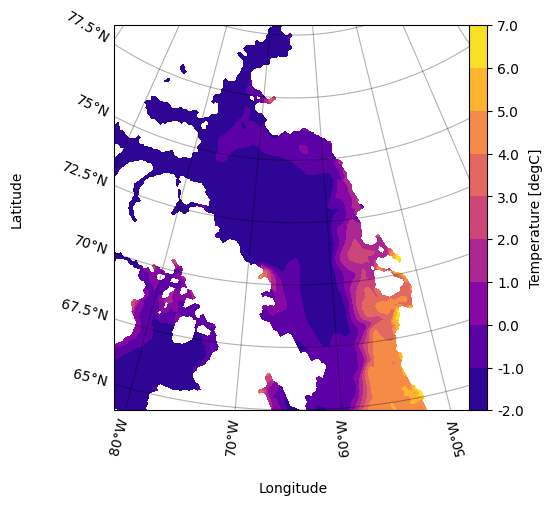

In [102]:
 # region, proj_size = au.init_location()
    
line_levels = 11
vmax = 7.
vmin = -2.
levels = np.arange(vmin,vmax+0.5)
#levels = line_levels*len(file_list)
cmap = 'plasma'


location_info = init_location(lat_range,lon_range)


fig, ax = plt.subplots(figsize=[5,5],
                        subplot_kw={'projection': ccrs.LambertConformal(
                                                        central_longitude=location_info['central_longitude'],
                                                        standard_parallels=location_info['standard_parallels'])})

ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]])
cf = ax.contourf(lon,lat,var_clim[6,0,:,:],levels=levels,
                 vmin=vmin,vmax=vmax,cmap='plasma',transform=ccrs.PlateCarree())

# Create grid-line labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False,
            y_inline=False, color='k', alpha=.3, linewidths=.01)
gl.right_labels = gl.top_labels = False

# Set axis labels
# To show x label only at the bottom most row
ax.text(0.5, -0.22, 'Longitude', va='bottom', ha='center',
            rotation='horizontal', rotation_mode='anchor',
            transform=ax.transAxes)
# To show y label only at left most column
ax.text(-0.25, 0.55, 'Latitude', va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes)

# Set Color-bar
axins = inset_axes(ax, width="5%", height="100%", loc='right', borderpad=-1)
lims = [vmin, vmax]
label = 'Temperature [degC]'
fig.colorbar(cf,cax=axins, orientation="vertical", extend='both',label=label, format='%.1f',)